In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pickle as pkl
from sklearn.model_selection import train_test_split

from tf_logging import TF_LOGGING
from stacked_lstm import _MODEL as Stacked_LSTM
from cnn_lstm import _MODEL as CNN_LSTM
from lstm import _MODEL as LSTM


tf_logging = TF_LOGGING()

cnn_lstm = CNN_LSTM().create_model()
stacked_lstm = Stacked_LSTM().create_model()
lstm = LSTM().create_model()

cnn_lstm.summary()

stacked_lstm.summary()

lstm.summary()

# tf.keras.utils.plot_model(cnn_lstm, to_file= "lstm.png", show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 12, 1)]           0         
                                                                 
 Conv1 (Conv1D)              (None, 12, 128)           256       
                                                                 
 Conv2 (Conv1D)              (None, 12, 128)           16512     
                                                                 
 MaxPool (MaxPooling1D)      (None, 6, 128)            0         
                                                                 
 LSTM1 (LSTM)                (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 FC (Dense)                  (None, 1)                 129   

## Loading Data

In [2]:
#Load the data
with open('X.pkl', 'rb') as f:
    X = pkl.load(f)
with open('Y.pkl', 'rb') as f:
    Y = pkl.load(f)

#Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

#Split into training, testing, and validation sets using scikit-learn
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True, random_state=42)

#Reshape the data to fit the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)
Y_val = Y_val.reshape(Y_val.shape[0], 1)

#Print the shapes and types of the data
print('X_train shape:', X_train.shape, 'type:', type(X_train))
print('Y_train shape:', Y_train.shape, 'type:', type(Y_train))
print('X_test shape:', X_test.shape, 'type:', type(X_test))
print('Y_test shape:', Y_test.shape, 'type:', type(Y_test))
print('X_val shape:', X_val.shape, 'type:', type(X_val))
print('Y_val shape:', Y_val.shape, 'type:', type(Y_val))

val_performance = {}
performance = {}

X_train shape: (310194, 12, 1) type: <class 'numpy.ndarray'>
Y_train shape: (310194, 1) type: <class 'numpy.ndarray'>
X_test shape: (96936, 12, 1) type: <class 'numpy.ndarray'>
Y_test shape: (96936, 1) type: <class 'numpy.ndarray'>
X_val shape: (77549, 12, 1) type: <class 'numpy.ndarray'>
Y_val shape: (77549, 1) type: <class 'numpy.ndarray'>


# Train and Save Models

In [5]:

models = [cnn_lstm, stacked_lstm, lstm]

for i,model in enumerate(models):
    Adam = tf.keras.optimizers.Adam(learning_rate=0.01)
    callback = tf_logging.create(f"logs/{i}")
    model.compile(loss='mse', optimizer=Adam, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.fit(X_train,Y_train,epochs=10, validation_data=(X_val,Y_val), callbacks=callback)
    tf.keras.models.save_model(model,f"model_{i}.h5")


Epoch 1/10
9694/9694 [==============================] - 51s 5ms/step - loss: 0.0380 - root_mean_squared_error: 0.1949 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1920
Epoch 2/10
9694/9694 [==============================] - 51s 5ms/step - loss: 7.8639 - root_mean_squared_error: 2.8043 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1958
Epoch 3/10
9694/9694 [==============================] - 51s 5ms/step - loss: 4.3867 - root_mean_squared_error: 2.0945 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2163
Epoch 4/10
9694/9694 [==============================] - 51s 5ms/step - loss: 0.0442 - root_mean_squared_error: 0.2102 - val_loss: 0.0395 - val_root_mean_squared_error: 0.1988
Epoch 5/10
9694/9694 [==============================] - 51s 5ms/step - loss: 0.0815 - root_mean_squared_error: 0.2856 - val_loss: 0.0988 - val_root_mean_squared_error: 0.3143
Epoch 6/10
9694/9694 [==============================] - 51s 5ms/step - loss: 0.0988 - root_mean_squared_error: 0.3143 - val_l

# Load Models

In [3]:
models = []

for model in ["model_0.h5","model_1.h5","model_2.h5"]:
    models.append(tf.keras.models.load_model(f"models/{model}"))
    print("Loaded:", model)


Loaded: model_0.h5
Loaded: model_1.h5
Loaded: model_2.h5


## Plotting Function

In [58]:
def plot(inputs, labels, model=None, isBaseline=False, max_subplots=3):
  #shuffle the data and labels in unison
  indices = np.arange(inputs.shape[0])
  print(np.random.get_state()[2])
  np.random.seed(194)
  np.random.shuffle(indices)
  inputs = inputs[indices]
  labels = labels[indices]
  
  plt.figure(figsize=(12, 8))
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'Energy Generation [normed]')
    plt.plot(inputs[n],
             label='Inputs', marker='.', zorder=-10)

    plt.scatter(x=len(inputs[n]), y=labels[n],
                edgecolors='k', label='True', c='#2ca02c', s=64)
    if model is not None and isBaseline is not True:
        model_names = ["CNN_LSTM", "Stack_LSTM", "LSTM"]
        model_color = ["#4e18c7","#c7186e","#91c718"]
        for i, model in enumerate(models):
            prediction = model.predict(np.reshape(inputs[n],(-1,12,1)))[0][0]
        # Extract the predictions from the list of arrayss
            plt.scatter(x=len(inputs[n]), y=prediction, marker='X', edgecolors='k', label=model_names[i],
                        c=model_color[i], s=64)
    if model is not None and isBaseline is not False:
      prediction = model.predict(np.reshape(inputs[n],(-1,12,1)))[0][0]
      plt.scatter(x=len(inputs[n]), y=prediction, marker='X', edgecolors='k', label="Baseline Prediction",
                  c="#FF2800", s=64)
    if n == 0:
      plt.legend()

  plt.xlabel('Time [Months]')

## Baseline Model

Just guess that the next data point is the same as the last data point.

In [59]:
class Baseline(tf.keras.Model):
  def __init__(self):
    super().__init__()

  def call(self, inputs):
    # return the last input in the time axis
    return inputs[:, -1:, :]

In [60]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(X_val, Y_val, verbose=0)
performance['Baseline'] = baseline.evaluate(X_test, Y_test, verbose=0)


print(performance)


{'Baseline': [0.04755082353949547, 0.21806150674819946]}


# Baseline Model Plot

558
1/1 [==============================] - 0s 14ms/step


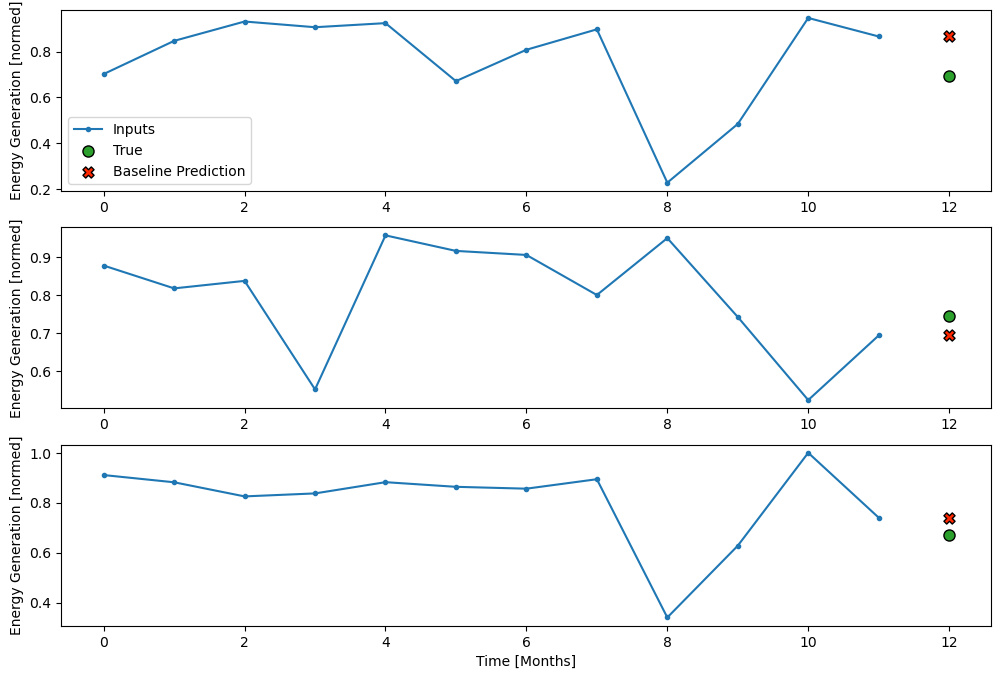

In [61]:
plot(inputs=X_val, labels=Y_val, model=baseline, isBaseline=True)

# Custom Models Plot

558
1/1 [==============================] - 0s 15ms/step


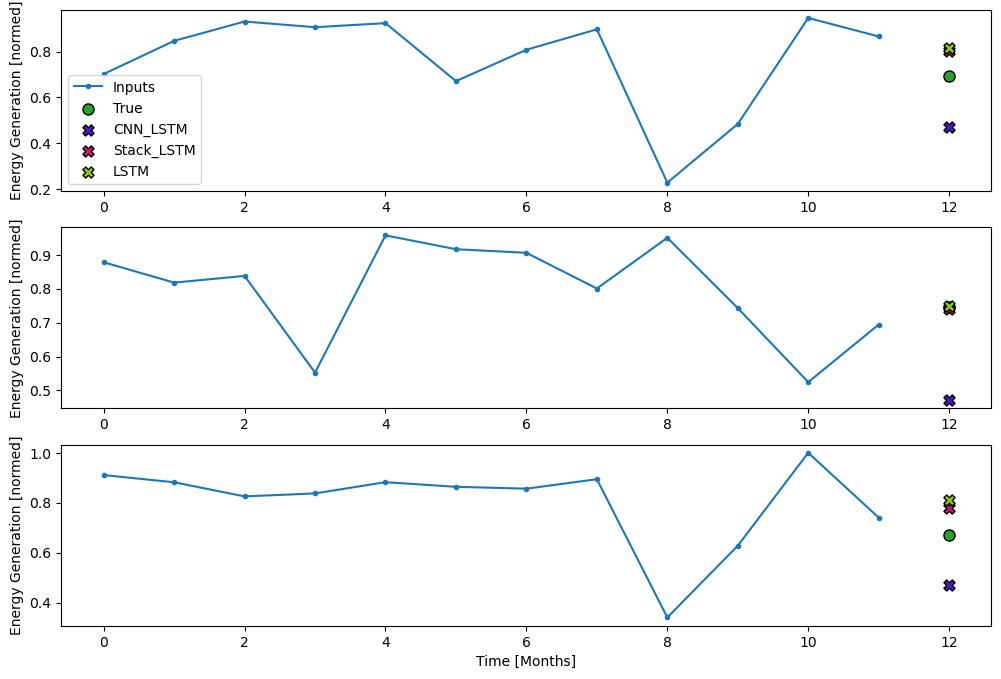

In [45]:
plot(inputs=X_val, labels=Y_val, model=models)

# How To Insert Custom Input

In [9]:
from predicter import PREDICTER
import pandas as pd
data = pd.read_csv("combined.csv")

pred = PREDICTER(data,cnn_lstm,"3-A1ST-1")

prediction = pred.predict([21704,3676,122115,121116,96448,105658,109108,95838,97307,122318,118503,108906])

print(prediction)



[94096.9]


# Load Tensorboard

In [46]:
%load_ext tensorboard


# Run Tensorboard

In [48]:
%tensorboard --logdir logs --port 8081